In [1]:
import pickle
from sympy import *
from binarize_features import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

language_model = 'roberta-base'
country_file = 'data/country_list_continents_new.csv'
occ_file = 'data_new/occupations_subset.csv'
binarizer = Binarizer(country_file, 5, occ_file)

c:\Users\sophi\Miniconda3\envs\MT\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(binarizer.occupation_lookup)

{'nurse': 0, 'fashion_designer': 1, 'dancer': 2, 'footballer': 3, 'industrialist': 4, 'boxer': 5, 'singer': 6}


In [4]:
language_model = 'bert-large-cased'
number = 1

### Loading

Load the extracted rule set and the background used from the corresponding files.

In [5]:
with open('data_new/rule_extraction/' + language_model + '_rules_' + str(number) + '.txt', 'rb') as f:
    h = pickle.load(f)
with open('data/background.txt', 'rb') as f:
    background = pickle.load(f)

In [6]:
def get_all_rules(h, background):
    all_rules = []
    for rule in h:
        if rule not in background:
            expr = sstr(rule)
            all_rules.append(expr)
            #print(expr)
    return all_rules
all_rules = get_all_rules(h, background)

In [7]:
def make_rule_lists(all_rules):
    rules = []
    negations = []
    implications = []
    for rule in all_rules:
        if '~' in rule:
            idx = []
            if not '(' in rule:
                idx.append(int(rule.replace('~v', '')))
            else:
                for s in rule.split(' '):
                    if 'v' in s:
                        s = s.replace('~(', '')
                        s = s.replace(')', '')
                        idx.append(int(s.replace('v', '')))
            rules.append({'head' : '','body' : idx})
            negations.append(idx)
        else:
            body, head = rule.split(', ')
            body_idx = []
            for s in body.split(' '):
                if 'v' in s:
                    s = s.replace('Implies(', '')
                    body_idx.append(int(s.replace('v', '')))
            head_idx = head.replace('v', '').replace(')','')
            rules.append({'head' : head_idx, 'body' : body_idx})
            implications.append({'head' : head_idx, 'body' : body_idx})
    return (rules, negations, implications)
(rules, negations, implications) = make_rule_lists(all_rules)

In [2]:
def get_lookup(binarizer):
    total_lookup = []
    for index in range(len(binarizer.age_containers) + 1):
        if index == 0:
            total_lookup.append("before " + str(binarizer.age_containers[index]))
        elif index == len(binarizer.age_containers):
            total_lookup.append("after " + str(binarizer.age_containers[index-1]))
        else:
            total_lookup.append("between " + str(binarizer.age_containers[index-1]) + " and " + str(binarizer.age_containers[index]))
    for v in binarizer.continent_lookup.keys():
        total_lookup.append(v)
    for v in binarizer.occupation_lookup.keys():
        total_lookup.append(v)
    total_lookup.append('female')
    total_lookup.append('male')
    #print({i : total_lookup[i] for i in range(len(total_lookup))})
    return total_lookup
total_lookup = get_lookup(binarizer)
print({i : total_lookup[i] for i in range(len(total_lookup))})

{0: 'before 1875', 1: 'between 1875 and 1925', 2: 'between 1925 and 1951', 3: 'between 1951 and 1970', 4: 'after 1970', 5: 'North America', 6: 'Africa', 7: 'Europe', 8: 'Asia', 9: 'South America', 10: 'Oceania', 11: 'Eurasia', 12: 'Americas', 13: 'Australia', 14: 'nurse', 15: 'fashion_designer', 16: 'dancer', 17: 'footballer', 18: 'industrialist', 19: 'boxer', 20: 'singer', 21: 'violinist', 22: 'female', 23: 'male'}


In [9]:
def negation_to_string(rule, total_lookup):
    s = "not ("
    for variable in rule:
        s = s + total_lookup[variable] + " & "
    s = s[:-2]
    s = s + ")"
    return s

def negation_to_latex(rule, total_lookup):
    s = "$"
    for variable in rule:
        s = s + "\\text{" + total_lookup[variable] + "} \\land "
    s = s[:-6]
    s = s + " \\rightarrow \\bot$"
    return s

def get_negation_strings(negations, total_lookup):
    negations_strings = []
    for rule in negations:
        negations_strings.append(negation_to_string(rule, total_lookup))
    return negations_strings
negations_strings = get_negation_strings(negations, total_lookup)

Get only those implications that are not covered by the negations

In [10]:
def implication_to_string(rule, total_lookup):
    s = ""
    for variable in rule['body']:
        s = s + total_lookup[variable] + " & "
    s = s[:-2]
    s = s + " ---> " + total_lookup[int(rule['head'])]
    return s

def implication_to_latex(rule, total_lookup):
    s = "$"
    for variable in rule['body']:
        s = s + "\\text{" + total_lookup[variable] + "} \\land "
    s = s[:-6]
    s = s + " \\rightarrow \\text{" + total_lookup[int(rule['head'])] + "} $"
    return s

def get_relevant_implications(implications, negations, total_lookup):
    implication_strings = []
    for rule in implications:
        if rule['body'] not in negations:
            implication_strings.append(implication_to_string(rule, total_lookup))
    return implication_strings
implication_strings = get_relevant_implications(implications, negations, total_lookup)

In [11]:
string_rules = [*negations_strings, *implication_strings]

## Averaging / Summarizing all experiments per model

In [12]:
models = ['roberta-base', 'roberta-large', 'bert-base-cased', 'bert-large-cased']
language_model = models[2]
experiments = range(1,11)

In [13]:
with open('data/background.txt', 'rb') as f:
    background = pickle.load(f)

In [15]:
total_lookup = get_lookup(binarizer)

{0: 'before 1875', 1: 'between 1875 and 1925', 2: 'between 1925 and 1951', 3: 'between 1951 and 1970', 4: 'after 1970', 5: 'North America', 6: 'Africa', 7: 'Europe', 8: 'Asia', 9: 'South America', 10: 'Oceania', 11: 'Eurasia', 12: 'Americas', 13: 'Australia', 14: 'fashion_designer', 15: 'nurse', 16: 'dancer', 17: 'priest', 18: 'footballer', 19: 'banker', 20: 'singer', 21: 'lawyer', 22: 'mathematician', 23: 'diplomat', 24: 'female', 25: 'male'}


### Import all extracted rules of all experiments

Importing the rules of all experiments, sorting them into negations and implications and removing those implications that are redundant with the negations.

In [60]:
eq = 200

In [61]:
all_negations = []
all_implications = []
for e in experiments:
    with open('data_new/rule_extraction_new/results/' + language_model + '_rules_' + str(eq) + '_' + str(e) + '.txt', 'rb') as f:
        h = pickle.load(f)
    all_rules = get_all_rules(h, background)
    (rules, negations, implications) = make_rule_lists(all_rules)
    all_negations = [*all_negations, *negations]
    all_implications = [*all_implications, *implications]

In [62]:
def count_lists(l):
    counts = []
    sublists = []
    for sublist in l:
        if sublist not in sublists:
            counts.append([sublist, l.count(sublist)])
            sublists.append(sublist)
    return counts

In [63]:
relevant_implications = []
for rule in all_implications:
    if rule['body'] not in all_negations:
        relevant_implications.append(rule)

In [64]:
negations_count = count_lists(all_negations)
implications_count = count_lists(relevant_implications)

In [65]:
filename_string = 'data_new/rule_extraction_new/formatted/' + language_model + '_' + str(eq) +'.txt'
filename_latex = 'data_new/rule_extraction_new/formatted/' + language_model + '_' + str(eq) +'_latex.txt'
male = 0
female = 0
total = 0

In [66]:
for rule, count in sorted(negations_count, key=lambda rule: rule[1], reverse=True):
    rule_string = negation_to_string(rule, total_lookup)
    if count > 1:
        total = total + 1
        if "female" in rule_string:
            female = female + 1
        elif "male" in rule_string:
            male = male + 1

for rule, count in sorted(implications_count, key=lambda rule: rule[1], reverse=True):
    rule_string = implication_to_string(rule, total_lookup)
    if count > 1:
        total = total + 1
        if "female" in rule_string:
            female = female + 1
        elif "male" in rule_string:
            male = male + 1

print(total, male, female)

64 18 46


In [67]:
values_100_over6 = [[1, 6],   #male, female
          [4, 5],
          [1, 6],
          [3, 5]]

values_100_over1 = [[7, 6],   #male, female
          [5, 11],
          [2, 11],
          [4, 14]]


values_50_over6 = [[1, 0],
             [2, 0],
             [0, 0],
             [1, 0]]

values_50_over1 = [[4, 12],
             [4, 9],
             [5, 9],
             [5, 10]]

   amount  gender          model
0       4    male   roberta-base
1      12  female   roberta-base
2       4    male  roberta-large
3       9  female  roberta-large
4       5    male      bert-base
5       9  female      bert-base
6       5    male     bert-large
7      10  female     bert-large


[Text(0.5, 1.0, 'Gender related to by extracted rules')]

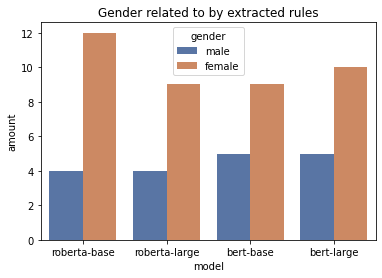

In [68]:
data = pd.DataFrame({'amount' : np.array(values_50_over1).flatten(), 
                    'gender' : ['male', 'female', 'male', 'female', 'male', 'female', 'male', 'female'], 
                    'model' : ['roberta-base', 'roberta-base', 'roberta-large', 'roberta-large', 'bert-base', 'bert-base', 'bert-large', 'bert-large']})
print(data)
ax = sns.barplot(data = data, x='model', y='amount', hue='gender', palette='deep')
ax.set(title="Gender related to by extracted rules")
#ax.set_yticks(range(2))

In [69]:
for rule, count in sorted(negations_count, key=lambda rule: rule[1], reverse=True):
    rule_string = negation_to_string(rule, total_lookup)
    with open(filename_string, 'a') as f:
        line = "{:.3f}  :  {rule}".format(count/10, rule=rule_string)
        #print(line)
        f.write(line + '\n')
    with open(filename_latex, 'a') as f:
        line = "{} & {rule} \\\\".format(count, rule=negation_to_latex(rule, total_lookup))
        f.write(line + '\n')
    
    if count > 1:
        total = total + 1
        if "female" in rule_string:
            female = female + 1
        elif "male" in rule_string:
            male = male + 1

In [70]:
for rule, count in sorted(implications_count, key=lambda rule: rule[1], reverse=True):
    rule_string = implication_to_string(rule, total_lookup)
    with open(filename_string, 'a') as f:
        line = "{:.3f}  :  {rule}".format(count/10, rule=rule_string)
        #print(line)
        f.write(line + '\n')
    with open(filename_latex, 'a') as f:
        line = "{} & {rule} \\\\".format(count, rule=implication_to_latex(rule, total_lookup))
        f.write(line + '\n')

    if count > 1:
        total = total + 1
        if "female" in rule_string:
            female = female + 1
        elif "male" in rule_string:
            male = male + 1

## One-cell

In [16]:
def count_lists(l):
    counts = []
    sublists = []
    for sublist in l:
        if sublist not in sublists:
            counts.append([sublist, l.count(sublist)])
            sublists.append(sublist)
    return counts

In [18]:
#one-cell
models = ['roberta-base', 'roberta-large', 'bert-base-cased', 'bert-large-cased']
eqs = [50, 100, 200]
experiments = range(1,11)
with open('data/background.txt', 'rb') as f:
    background = pickle.load(f)
total_lookup = get_lookup(binarizer)

for lm in models:
    for eq in eqs:
        all_negations = []
        all_implications = []
        for e in experiments:
            with open('data_new/rule_extraction_new/results/' + lm + '_rules_' + str(eq) + '_' + str(e) + '.txt', 'rb') as f:
                h = pickle.load(f)
            all_rules = get_all_rules(h, background)
            (rules, negations, implications) = make_rule_lists(all_rules)
            all_negations = [*all_negations, *negations]
            all_implications = [*all_implications, *implications]

        relevant_implications = []
        for rule in all_implications:
            if rule['body'] not in all_negations:
                relevant_implications.append(rule)

        negations_count = count_lists(all_negations)
        implications_count = count_lists(relevant_implications)

        filename_string = 'data_new/rule_extraction_new/formatted/' + lm + '_' + str(eq) +'.txt'
        filename_latex = 'data_new/rule_extraction_new/formatted/' + lm + '_' + str(eq) +'_latex.txt'

        for rule, count in sorted(negations_count, key=lambda rule: rule[1], reverse=True):
            rule_string = negation_to_string(rule, total_lookup)
            with open(filename_string, 'a') as f:
                line = "{:.3f}  :  {rule}".format(count/10, rule=rule_string)
                #print(line)
                f.write(line + '\n')
            with open(filename_latex, 'a') as f:
                line = "{} & {rule} \\\\".format(count, rule=negation_to_latex(rule, total_lookup))
                f.write(line + '\n')

        for rule, count in sorted(implications_count, key=lambda rule: rule[1], reverse=True):
            rule_string = implication_to_string(rule, total_lookup)
            with open(filename_string, 'a') as f:
                line = "{:.3f}  :  {rule}".format(count/10, rule=rule_string)
                #print(line)
                f.write(line + '\n')
            with open(filename_latex, 'a') as f:
                line = "{} & {rule} \\\\".format(count, rule=implication_to_latex(rule, total_lookup))
                f.write(line + '\n')

{0: 'before 1875', 1: 'between 1875 and 1925', 2: 'between 1925 and 1951', 3: 'between 1951 and 1970', 4: 'after 1970', 5: 'North America', 6: 'Africa', 7: 'Europe', 8: 'Asia', 9: 'South America', 10: 'Oceania', 11: 'Eurasia', 12: 'Americas', 13: 'Australia', 14: 'fashion_designer', 15: 'nurse', 16: 'dancer', 17: 'priest', 18: 'footballer', 19: 'banker', 20: 'singer', 21: 'lawyer', 22: 'mathematician', 23: 'diplomat', 24: 'female', 25: 'male'}


## Evaluate Runtimes

In [19]:
models = ['roberta-base', 'roberta-large', 'bert-base-cased', 'bert-large-cased']
experiments = range(1,11)
eq = [50, 100, 200]
path = 'data_new/rule_extraction_new/results/{lm}_runtime_{eq}_{experiment}.txt'

In [20]:
for e in eq:
    for lm in models:
        total_runtime = 0
        average_iteration_runtime = 0
        for exp in experiments:
            with open(path.format(lm=lm, eq=e, experiment=exp)) as f:
                data = f.read()
            data_dict = json.loads(data)
            total_runtime = total_runtime + float(data_dict['data']['runtime'])
            average_iteration_runtime = average_iteration_runtime + float(data_dict['data']['runtime per iteration'])
        total_runtime = total_runtime / len(experiments)
        average_iteration_runtime = average_iteration_runtime / len(experiments)
        print("{lm} - {e} EQs:".format(lm=lm, e=e))
        print("\truntime average: {r:.2f} sec = {r1:.2f} min = {r2:.2f} h".format(r=total_runtime, r1 = total_runtime/60, r2=total_runtime/60/60))
        print("\truntime per iteration average: {r:.2f} sec".format(r=average_iteration_runtime))
            

roberta-base - 50 EQs:
	runtime average: 4185.85 sec = 69.76 min = 1.16 h
	runtime per iteration average: 83.72 sec
roberta-large - 50 EQs:
	runtime average: 7753.08 sec = 129.22 min = 2.15 h
	runtime per iteration average: 155.06 sec
bert-base-cased - 50 EQs:
	runtime average: 4304.17 sec = 71.74 min = 1.20 h
	runtime per iteration average: 86.08 sec
bert-large-cased - 50 EQs:
	runtime average: 7800.79 sec = 130.01 min = 2.17 h
	runtime per iteration average: 156.02 sec
roberta-base - 100 EQs:
	runtime average: 11089.24 sec = 184.82 min = 3.08 h
	runtime per iteration average: 110.89 sec
roberta-large - 100 EQs:
	runtime average: 18523.93 sec = 308.73 min = 5.15 h
	runtime per iteration average: 185.24 sec
bert-base-cased - 100 EQs:
	runtime average: 11624.35 sec = 193.74 min = 3.23 h
	runtime per iteration average: 116.24 sec
bert-large-cased - 100 EQs:
	runtime average: 18237.59 sec = 303.96 min = 5.07 h
	runtime per iteration average: 182.38 sec
roberta-base - 200 EQs:
	runtime ave

## Evaluate Negation Rules

In [29]:
category_data = pd.DataFrame({
                    'occupation' : ['fashion_designer', 'nurse', 'dancer', 'priest', 'footballer', 'banker', 'singer', 'lawyer', 'mathematician', 'diplomat'], 
                    'category' : ['creative', 'care', 'creative', 'religious', 'sports', 'needs_degree', 'creative', 'needs_degree', 'needs_degree', 'needs_degree']})
print(category_data)
categories = {'fashion_designer' : 'creative', 'nurse' : 'care', 'dancer' : 'creative', 'priest' : 'religious', 'footballer' : 'sports', 'banker' : 'needs_degree', 'singer' : 'creative', 'lawyer' : 'needs_degree', 'mathematician' : 'needs_degree', 'diplomat' : 'needs_degree'}

         occupation      category
0  fashion_designer      creative
1             nurse          care
2            dancer      creative
3            priest     religious
4        footballer        sports
5            banker  needs_degree
6            singer      creative
7            lawyer  needs_degree
8     mathematician  needs_degree
9          diplomat  needs_degree


In [ ]:
needs_degree = ['lawyer', 'diplomant', 'mathematician', 'banker']
sports = ['footballer']
creative = ['dancer', 'singer', 'fashion_designer']
religious = ['priest']
care = ['nurse']

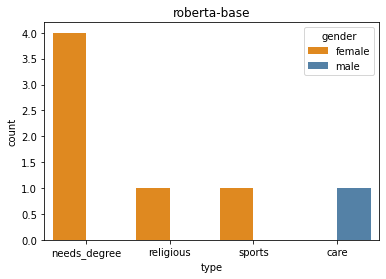

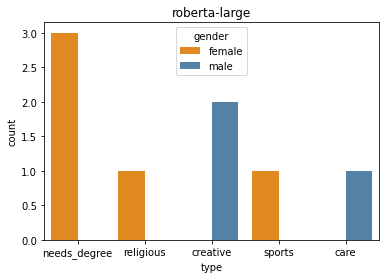

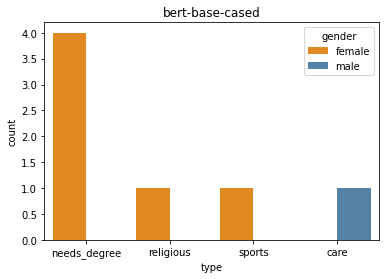

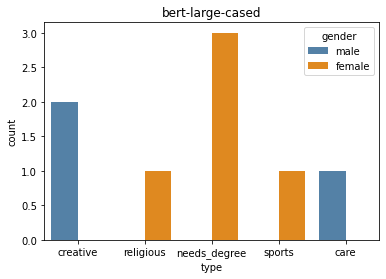

In [55]:
#one-cell
models = ['roberta-base', 'roberta-large', 'bert-base-cased', 'bert-large-cased']
eqs = [200]
experiments = range(1,11)
with open('data/background.txt', 'rb') as f:
    background = pickle.load(f)
total_lookup = get_lookup(binarizer)
eq = 200

data_arrays = {}
total_array = []
for lm in models:
    all_negations = []
    all_implications = []
    for e in experiments:
        with open('data_new/rule_extraction_new/results/' + lm + '_rules_' + str(eq) + '_' + str(e) + '.txt', 'rb') as f:
            h = pickle.load(f)
        all_rules = get_all_rules(h, background)
        (rules, negations, implications) = make_rule_lists(all_rules)
        all_negations = [*all_negations, *negations]

    negations_count = count_lists(all_negations)
    data = []
    for rule, count in sorted(negations_count, key=lambda rule: rule[1], reverse=True):
        rule_string = negation_to_string(rule, total_lookup)
        if count > 6 and len(rule) == 2:
            total_array.append([lm, total_lookup[rule[1]], categories[total_lookup[rule[0]]]])
            data.append([total_lookup[rule[1]], categories[total_lookup[rule[0]]]])
    data_arrays[lm] = data

for lm in models:
    frame = pd.DataFrame(data_arrays[lm], columns=['gender', 'type'])
    ax = sns.countplot(data = frame, x='type', hue='gender', palette={'female': 'darkorange', 'male': 'steelblue'})
    ax.set(title=lm)
    plt.show()
